# Определение возраста покупателей

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Цели-исследования" data-toc-modified-id="Цели-исследования-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Цели исследования</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Выводы,-исследовательский-анализ-данных" data-toc-modified-id="Выводы,-исследовательский-анализ-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выводы, исследовательский анализ данных</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></li><li><span><a href="#Итоговый-вывод:" data-toc-modified-id="Итоговый-вывод:-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Итоговый вывод:</a></span></li></div>

**Цели исследования:**

Для супермаркета «Хлеб-Соль» подготовить нейросетевую модель для системы компьютерного зрения. Задача супермаркета состоит в определении возраста клиентов по фотофиксации в прикассовой зоне.

По набору данных <a href='https://chalearnlap.cvc.uab.cat/dataset/26/description/'>APPA-REAL</a> необходимо построить модель, которая по фотографии определит приблизительный возраст человека.


**Ход исследования**
- Исследовательский анализ набора фотографий
- Подготовка данных к обучению
    - Обучение нейронной сети и рассчет её качества
    - Анализ обученной модели
- Итоговый вывод

**Результаты исследования**
- В ходе исследования были подготовлены и предобработаны данные (средствами библиотеки Keras фотографии из набора APPA-REAL были приведены к тензорному представлению с добавлением некоторых аугментаций)
- В стороннем тренажере проведено обучение сверточной нейросетевой модели на хребте модели ResNet-50 с добавлением полносвязных регрессионных слоев, активируемых ReLU. 
- Цель исследования была достигнута: получены удовлетворительные результаты модели по метрике МАЕ (меньше 8)

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
path = '/datasets/faces/'
labels = pd.read_csv(path + 'labels.csv')

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Всего 7591 изображений. Для обучения глубокой нейронной сети с нуля такого количества данных как правило недостаточно: она быстро переобучится и будет показывать на тестовой выборке неадекватно высокий loss.

Это значит, что в данной работе следует применить методы увеличения обучающей выборки путем применения "дополнений" (`augmentations`), также следует воспользоваться `transfer learning` - методом обучения, основанном на использовании хребта нейронной сети (`backbone`), уже предобученной на других изображениях.

In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


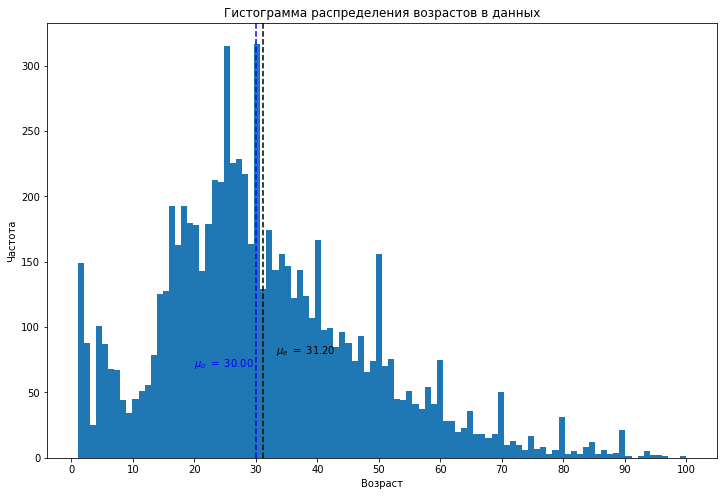

In [6]:
labels['real_age'].plot.hist(bins=100, figsize=(12, 8), title='Гистограмма распределения возрастов в данных')
mean = labels['real_age'].mean(); mode = labels['real_age'].mode()[0]
plt.axvline(mean, color='black', ls='--'); plt.text(mean+2, 80, f'$\mu_e\ =\ {mean:.2f}\ $')
plt.axvline(mode, color='blue', ls='--'); plt.text(mode-10, 70, f'$\mu_o\ =\ {mode:.2f}\ $', color='blue')
plt.xticks(np.linspace(0, 100, 11)); plt.xlabel('Возраст'); plt.ylabel('Частота');

Правоасимметричное распределение (мода меньше среднего значения), средний реальный возраст составляет 31.2 года. Заметны также пики около "круглых" значений (25, 30, 40, 50, 60, 70, 80, 90), что говорит о "примерном" возрасте многих людей в наборе данных, не смотря на то, что графа названа `real_age`.

In [7]:
datagen = ImageDataGenerator(rescale=1./255)

gen_flow = datagen.flow_from_dataframe(
    dataframe=pd.read_csv(path + 'labels.csv'),
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=42)

Found 7591 validated image filenames.


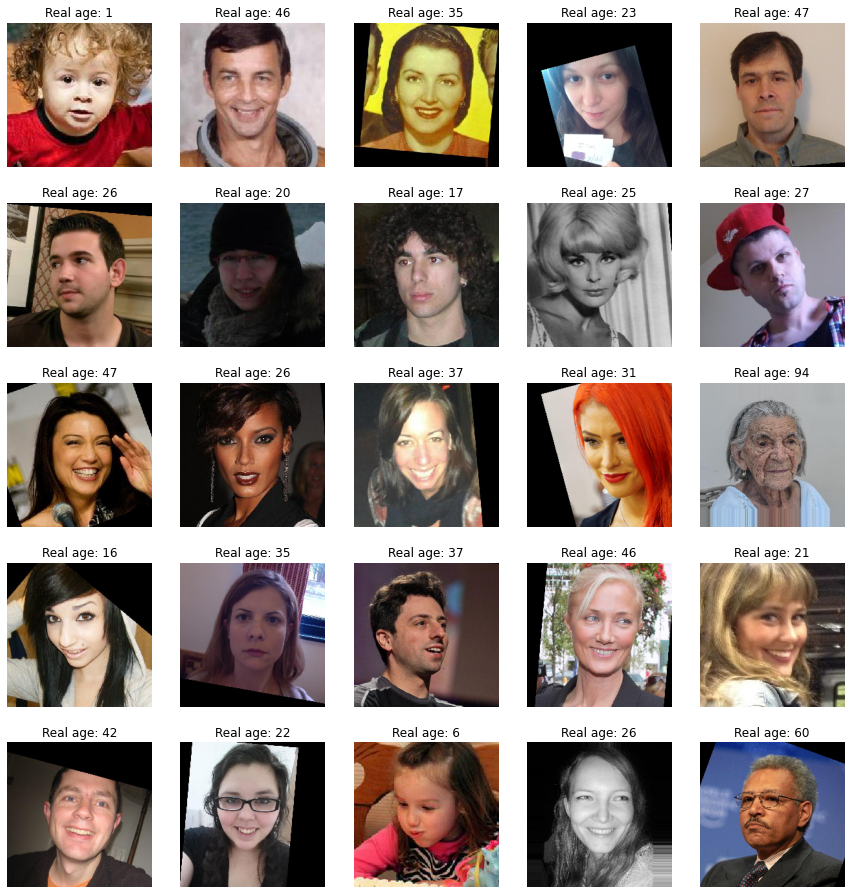

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 16))
axes = axes.ravel()
imgs, ages = next(gen_flow)
for i, img in enumerate(imgs[:25]):
    axes[i].imshow(img)
    axes[i].set_title(f'Real age: {ages[i]}')
    axes[i].axis('off')

### Выводы, исследовательский анализ данных
- Файл с целевым признаком был прочитан в датафрейм `labels`. Файл содержит 7591 строк, сопоставляющих имя изображения с возрастом человека на нем.
- Возраст людей в наборе данных распределен правоасимметрично, средний реальный возраст составляет 31.2 года, максимальный - 100 лет, минимальный - 1 год. Заметны пики около "круглых" значений (25, 30, 40, 50, 60, 70, 80, 90), что говорит о "примерном" возрасте многих людей в наборе данных.
- Изображения в наборе данных как цветные так и черно-белые (нужно задействовать все три канала RGB).
- В некоторых изображениях голова наклонена на какой-то угол, то есть для модели при обучении могуть быть полезны аугментации поворота (`rotation_range`) и горизонтального отражения (`horizontal_flip`)

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1./255,
        rotation_range=35,
        horizontal_flip=True
        )

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42)

    return train_gen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1./255)

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_gen_flow

def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)

    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model


def train_model(model, train_data, test_data,
                batch_size=None,
                epochs=15,
                steps_per_epoch=None,
                validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Using TensorFlow backend.

Found 6073 validated image filenames.

Found 1518 validated image filenames.


<class 'tensorflow.python.keras.engine.sequential.Sequential'>


Train for 190 steps, validate for 48 steps

Epoch 1/15

190/190 - 111s - loss: 188.7316 - mae: 10.2042 - val_loss: 402.0404 - val_mae: 14.9560

Epoch 2/15

190/190 - 104s - loss: 95.1966 - mae: 7.4313 - val_loss: 457.8420 - val_mae: 16.1147

Epoch 3/15

190/190 - 103s - loss: 72.7717 - mae: 6.5129 - val_loss: 316.6776 - val_mae: 13.0711

Epoch 4/15

190/190 - 103s - loss: 61.0627 - mae: 5.9407 - val_loss: 190.6528 - val_mae: 10.1656

Epoch 5/15

190/190 - 101s - loss: 49.0943 - mae: 5.3696 - val_loss: 103.3970 - val_mae: 7.4731

Epoch 6/15

190/190 - 104s - loss: 41.4890 - mae: 4.9357 - val_loss: 78.6810 - val_mae: 6.6478

Epoch 7/15

190/190 - 103s - loss: 34.6028 - mae: 4.5204 - val_loss: 80.2598 - val_mae: 6.7598

Epoch 8/15

190/190 - 101s - loss: 31.3056 - mae: 4.3101 - val_loss: 75.9637 - val_mae: 6.4764

Epoch 9/15

190/190 - 97s - loss: 26.0821 - mae: 3.9173 - val_loss: 73.6859 - val_mae: 6.7233

Epoch 10/15

190/190 - 96s - loss: 23.8243 - mae: 3.7361 - val_loss: 80.8748 - val_mae: 6.5245

Epoch 11/15

190/190 - 95s - loss: 20.7339 - mae: 3.4681 - val_loss: 75.0681 - val_mae: 6.6650

Epoch 12/15

190/190 - 95s - loss: 17.7620 - mae: 3.2149 - val_loss: 65.4196 - val_mae: 6.0297

Epoch 13/15

190/190 - 95s - loss: 16.7656 - mae: 3.1092 - val_loss: 70.7683 - val_mae: 6.2363

Epoch 14/15

190/190 - 95s - loss: 17.7864 - mae: 3.2037 - val_loss: 76.0505 - val_mae: 6.4911

Epoch 15/15

190/190 - 94s - loss: 16.0438 - mae: 3.0221 - val_loss: 68.9107 - val_mae: 6.1538


48/48 - 8s - loss: 68.9107 - mae: 6.1538

Test MAE: 6.1538

```

Достигнуто целевое значение по метрике MAE на тестовой выборке - меньше 8. 

### Анализ обученной модели

In [9]:
results_df = pd.DataFrame(index=range(1, 16),
                          data={'loss': [188.7316, 95.1966, 72.7717, 61.0627, 49.0943, 41.489, 34.6028,
                                         31.3056, 26.0821, 23.8243, 20.7339, 17.762, 16.7656, 17.7864, 16.0438],
                                'mae': [10.2042, 7.4313, 6.5129, 5.9407, 5.3696, 4.9357, 4.5204,
                                        4.3101, 3.9173, 3.7361, 3.4681, 3.2149, 3.1092, 3.2037, 3.0221],
                                'val_loss': [402.0404, 457.842, 316.6776, 190.6528, 103.397, 78.681, 80.2598,
                                            75.9637, 73.6859, 80.8748, 75.0681, 65.4196, 70.7683, 76.0505, 68.9107],
                                'val_mae': [14.956, 16.1147, 13.0711, 10.1656, 7.4731, 6.6478, 6.7598,
                                            6.4764, 6.7233, 6.5245, 6.665, 6.0297, 6.2363, 6.4911, 6.1538]}
                         )

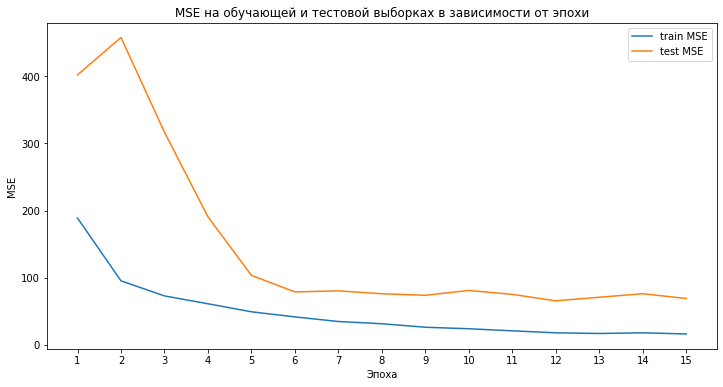

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(results_df[['loss', 'val_loss']])
plt.title('MSE на обучающей и тестовой выборках в зависимости от эпохи')
plt.legend(('train MSE', 'test MSE')); plt.ylabel('MSE'); plt.xlabel('Эпоха'); plt.xticks(range(1, 16));

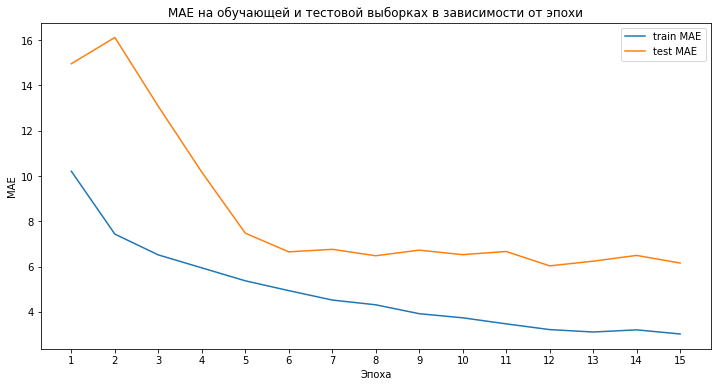

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(results_df[['mae', 'val_mae']])
plt.title('MAE на обучающей и тестовой выборках в зависимости от эпохи') 
plt.legend(('train MAE', 'test MAE')); plt.ylabel('MAE'); plt.xlabel('Эпоха'); plt.xticks(range(1, 16));

Хватило примерно 12 эпох для выхода на плато по MSE со скоростью обучения (`learning_rate`) оптимизатора Adam равной 0.0001. При б*о*льших значениях `learning_rate`эпох до выхода на плато понадобится меньше, но плато как правило настаёт "выше" (значение MAE также будет выше).

## Итоговый вывод

Цель исследования была достигнута, получены удовлетворительные результаты модели по метрике МАЕ:

- Для задачи предсказания возраста по фотографии была использована модель на основе сверточной нейронной сети ResNet-50 (в качестве `backbone`) к которой были добавлены 3 слоя для регрессии возраста.
- В ходе обучения в течение 15 эпох были получены значения метрики MAE равные 3.0221 и 6.1538 для обучающей и тестовой выборок соответственно, что меньше 8 и потому удовлетворяет условию поставленной задачи.
- Модель не переобучилась, но вышла на плато по `train MSE` и `train MAE`, то есть дальнейшее улучшение метрик качества скорее всего не будет значительным без корректировки `learning_rate` и изменения нейросетевой модели.